# Atividade Qiskit 3
* *Daniel Guimarães* - 1910462
* *Iury Saboia* - 1620675

N5 = 4, N6 = 6, N7 = 2

|φa não-normalizado⟩ = 5 |0⟩ + 7 e^(6iπ⁄11) |1⟩

norma = √(α^2+β^2)= √(25 + 49) = √74

|φa⟩ = (5/√74) |0⟩ + (7/√74) e^(6iπ⁄11) |1⟩

In [1]:
from qiskit import QuantumCircuit
from math import acos, sqrt, pi

def criar_circuito_especifico() -> QuantumCircuit:
    """
    Cria um circuito com 3 qubits, sendo o qubit 0: |φa⟩
    """
    circuito = QuantumCircuit(3, 3)
    phi = 6 * pi / 11
    theta = 2 * acos(5/sqrt(74))
    circuito.rz(-phi, 0)        # Rz(-ϕ)
    circuito.ry(-theta, 0)      # Ry(-θ)
    return circuito

## Questão 1.1
Crie um circuito quântico com 3 qubits no Qiskit, no qual *q0* corresponde ao qubit de Alice
a ser teleportado e os qubits *q1* e *q2* correspondem ao par emaranhado compartilhado por Alice e Bob,
respectivamente. Prepare *q0* no estado |φa⟩ e os qubits *q1* e *q2* no estado de Bell |ϕ+⟩.

In [2]:
qc = criar_circuito_especifico()    # inicia |φa⟩ no qubit 0
qc.h(1)                             # |0⟩ -> |+⟩
qc.cnot(1, 2)                       # |+⟩|0⟩ -> |ϕ+⟩

## Questão 1.2
Realize uma medida de Bell nos qubits *q0* e *q1* um número suficientemente grande de vezes e
obtenha a *matriz de densidade* do qubit *q2* .

In [3]:
qc_12 = qc.copy()
from qiskit import execute, Aer
from qiskit.tools.visualization import plot_histogram

# fazendo as operações dagger de H e CNOT (que são as próprias matrizes)
# medindo na base de bell |ϕ+⟩
qc_12.cnot(0, 1)
qc_12.h(0)
qc_12.measure(0, 0)
qc_12.measure(1, 1)
qc_12.draw()

┌────────────┐┌─────────────┐     ┌───┐┌─┐
q_0: ┤ Rz(-6π/11) ├┤ Ry(-1.9011) ├──■──┤ H ├┤M├
     └───┬───┬────┘└─────────────┘┌─┴─┐└┬─┬┘└╥┘
q_1: ────┤ H ├────────────■───────┤ X ├─┤M├──╫─
         └───┘          ┌─┴─┐     └───┘ └╥┘  ║ 
q_2: ───────────────────┤ X ├────────────╫───╫─
                        └───┘            ║   ║ 
c: 3/════════════════════════════════════╩═══╩═
                                         1   0

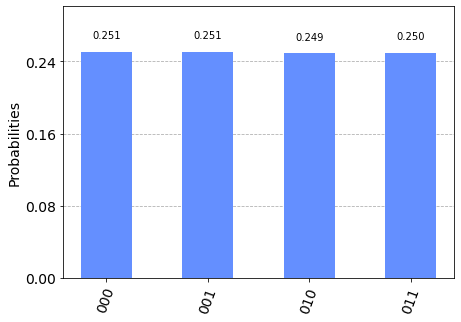

In [4]:
backend = Aer.get_backend('qasm_simulator')
res = execute(qc_12, backend, shots=10000).result()
counts = res.get_counts()
plot_histogram(counts)

Para encontrar a matriz de densidade, podemos pegar fazer o traço parcial do circuito

In [5]:
from qiskit.quantum_info import DensityMatrix, partial_trace

backend = Aer.get_backend('statevector_simulator')
statevectors = execute(qc_12, backend).result().get_statevector(qc, decimals=3)

matriz_densidade: DensityMatrix = partial_trace(statevectors, [0, 1])
print("Pureza: ", matriz_densidade.purity())
matriz_densidade.draw('latex')

Pureza:  (1.000392038416+0j)


<IPython.core.display.Latex object>

Repetindo as operações anteriores várias vezes, é possível notar que a matriz de densidade muda a cada simulação.
Afinal, o estado do Bob colapsa para algum dos quatro estados possíveis. Sem saber o estado que o qubit da Alice colapsou,
não é possível saber qual o estado original |φa⟩ .

## Questão 2: *Protocolo completo*
Complete o circuito anterior com as operações unitárias necessárias para implementar o protocoloc
original de Teletransporte Quântico.

In [16]:
from qiskit import QuantumRegister, ClassicalRegister
from math import pi, acos, sqrt

# criando as condições iniciais
qr = QuantumRegister(3, name='q')
cz, cx = ClassicalRegister(1, name='cz'), ClassicalRegister(1, 'cx')
c = QuantumCircuit(qr, cz, cx)

# primeira etapa: criar o meu estado
phi, theta = 6 * pi / 11, 2 * acos(5/sqrt(74))
c.rz(-phi, 0)        # Rz(-ϕ)
c.ry(-theta, 0)      # Ry(-θ)
c.barrier()

# segunda etapa: fazer o estado emaranhando de bell em 1 e 2
c.h(1)
c.cnot(1, 2)
c.barrier()

# terceira etapa: fazer as medidas de bell em 0 e 1
c.cnot(0, 1)
c.h(0)
c.measure(0, 0)
c.measure(1, 1)
c.barrier()

# quarta etapa: Bob faz suas operações e faz a sua medida
c.x(2).c_if(cx, 1)      # -> se 01 ou 11, deve fazer X
c.z(2).c_if(cz, 1)      # -> se 10 ou 11, deve fazer Z
# c.measure(2, 2)

c.draw()

┌────────────┐┌─────────────┐ ░            ░      ┌───┐┌─┐ ░        »
 q_0: ┤ Rz(-6π/11) ├┤ Ry(-1.9011) ├─░────────────░───■──┤ H ├┤M├─░────────»
      └────────────┘└─────────────┘ ░ ┌───┐      ░ ┌─┴─┐└┬─┬┘└╥┘ ░        »
 q_1: ──────────────────────────────░─┤ H ├──■───░─┤ X ├─┤M├──╫──░────────»
                                    ░ └───┘┌─┴─┐ ░ └───┘ └╥┘  ║  ░  ┌───┐ »
 q_2: ──────────────────────────────░──────┤ X ├─░────────╫───╫──░──┤ X ├─»
                                    ░      └───┘ ░        ║   ║  ░  └─╥─┘ »
cz: 1/════════════════════════════════════════════════════╬═══╩═══════╬═══»
                                                          ║   0    ┌──╨──┐»
cx: 1/════════════════════════════════════════════════════╩════════╡ = 1 ╞»
                                                          0        └─────┘»
«             
« q_0: ───────
«             
« q_1: ───────
«       ┌───┐ 
« q_2: ─┤ Z ├─
«       └─╥─┘ 
«      ┌──╨──┐
«cz: 1/╡ = 1 ╞
«      └─────┘
«cx: 1/═══════
«

Mostre que o estado final obtido por Bob corresponde a |φa⟩

c:\users\daniel\pycharmprojects\eng1116-computacao-quantica\env\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


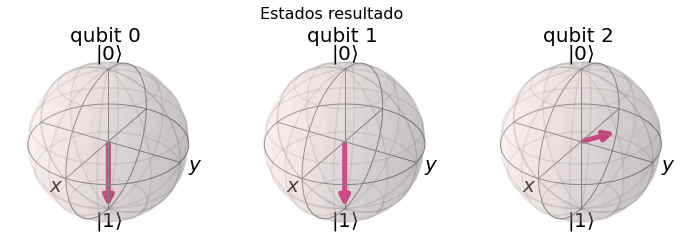

In [17]:
from qiskit.visualization import plot_bloch_multivector
backend = Aer.get_backend('aer_simulator')
c.save_statevector()
vetor_resultado = backend.run(c).result().get_statevector()
plot_bloch_multivector(vetor_resultado, title='Estados resultado')


c:\users\daniel\pycharmprojects\eng1116-computacao-quantica\env\lib\site-packages\qiskit\visualization\bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


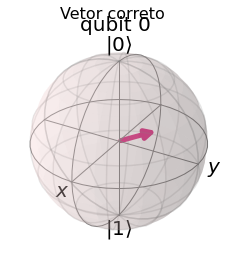

In [19]:
# criando o estado |φa⟩ para imprimir
# (5/√74) |0⟩ + (7/√74) e^(6iπ⁄11) |1⟩
qq = QuantumCircuit(1)
qq.rz(-phi, 0)        # Rz(-ϕ)
qq.ry(-theta, 0)      # Ry(-θ)
qq.save_statevector()
vetor_correto = backend.run(qq).result().get_statevector()
plot_bloch_multivector(vetor_correto, title='Vetor correto')

O resultado não viola o Teorema de Não-Clonagem pois o estado do Bob não é clonado, mas sim reconstruído usando
as informações dos estados da Alice.